In [1]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math
import time
import tqdm


done


(128, 128, 128)


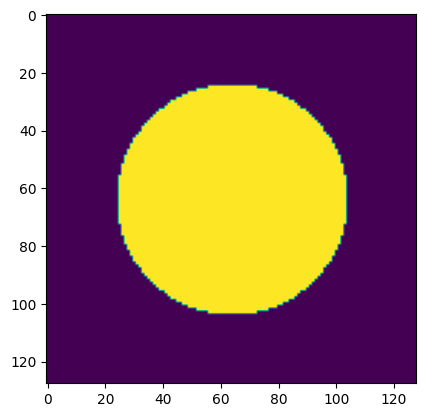

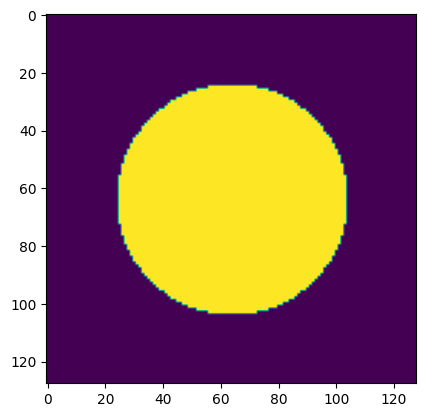

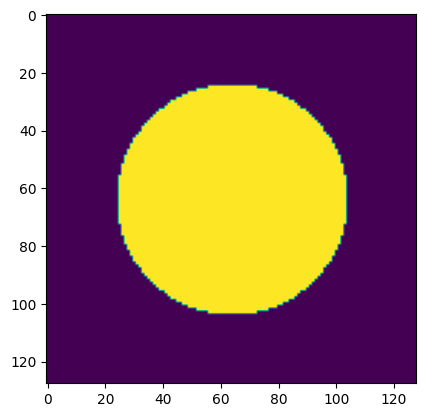

In [16]:
# configuration

starttime = time.time()
checkpointfilepath = r"checkpoints/sam_vit_h_4b8939.pth"
num_slices = 40
transform_list = platonics.get_cube_transforms()
# transform_list = platonics.get_icosahedron_transforms()
# transform_list = [
#     geometry.Transform(rotation = (0,0,0), translation = (0,0,0)),
#     geometry.Transform(rotation = (0,np.pi/2,0), translation = (0,0,0)),
#     geometry.Transform(rotation = (0,0,np.pi/2), translation = (0,0,0)),
# ]

test_1 = np.zeros((128, 128, 128))
test_1[16:112, 40:88, 56:72] = 150
test_1[111, 40:88, 56:72] = 255
test_1[16:112, 87, 56:72] = 255
test_1[16:112, 40:88, 71] = 255


test_2=np.zeros((128,128,128))
for i in range(128):
    for j in range(128):
        for k in range(128):
            if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5<40:
                test_2[i,j,k]=200
            

image = test_2
print(image.shape)

plt.imshow(image[:,:,64])
plt.show()
plt.imshow(image[:,64,:])
plt.show()
plt.imshow(image[64,:,:])
plt.show()

In [17]:
def get_prompt_slices(image, dirpath):
    slices_list = []
    for a, t in enumerate(transform_list):
        transformed_img = scale_transform.global_to_local(image, t)
        slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
        cv2.imwrite(f'{dirpath}/slice_{str(a).zfill(2)}.png', slice_transformed_img)

        slice_info = dict()
        slice_info['idx'] = transformed_img.shape[2]//2
        slice_info['transform'] = t
        slice_info['shape'] = transformed_img.shape
        slices_list.append(slice_info)    

    return slices_list

def get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices):
    pos_seg = []
    neg_seg = []

    for i, s in enumerate(slices_list):
        idx = s['idx']
        shape = s['shape']
        transform_curr = s['transform']

        for line in pos_polylines_slices[i]:
            global_line = []
            for point in line:
                point = point[:2] + [idx]
                print(point)
                transformed_point = scale_transform.index_to_coord(point, transform_curr, shape)
                print(transformed_point)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                pos_seg.append([global_line[j], global_line[j + 1]])

        for line in neg_polylines_slices[i]:
            global_line = []
            for point in line:
                point = point[:2] + [idx]
                transformed_point = scale_transform.index_to_coord(point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                neg_seg.append([global_line[j], global_line[j + 1]])
    # return zero centric points, global matrix
    return pos_seg, neg_seg

def get_intersections(matrix_shape, pos_seg, neg_seg, t, z):
    # calculate intersection points
    pos_intersects = []
    neg_intersects = []

    for p in pos_seg:
        # zero centric points, local matrix
        # z: zero centric
        intersection = scale_transform.get_intersection_point(t.apply_to_point(p[0]), t.apply_to_point(p[1]), z)
        if intersection:
            pos_intersects.append(t.apply_to_point(intersection, inverse=True))

    for n in neg_seg:
        intersection = scale_transform.get_intersection_point(t.apply_to_point(n[0]), t.apply_to_point(n[1]), z) # z should be supplied as a global coordinate
        if intersection:
            neg_intersects.append(t.apply_to_point(intersection, inverse=True))

    # need to transform inverse right?
    # zero centric, local matrix -> matrix indexing, global
    pos_intersects = [scale_transform.coord_to_index(pt, t, matrix_shape) for pt in pos_intersects]
    neg_intersects = [scale_transform.coord_to_index(pt, t, matrix_shape) for pt in neg_intersects]
    # print(f"zero centric pos intersects: {pos_intersects}")
    # pos_intersects = [scale_transform.scale_backward(np.array(pt), matrix_shape) for pt in pos_intersects]
    # neg_intersects = [scale_transform.scale_backward(np.array(pt), matrix_shape) for pt in neg_intersects]
    # print(f"matrix indexed pos intersects: {pos_intersects}")
    return pos_intersects, neg_intersects

def normalize (image):
    if np.min(image) == np.max(image):
        return np.stack([image, image, image], axis=2)
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    stacked = np.stack([image, image, image], axis=2)
    return stacked


In [18]:
# get prompt slices
folder = r"intermediates"


# image = utils.load3dmatrix(folder)
# print(image.shape)
# image = utils.padtocube(image)

slices_list = get_prompt_slices(image, folder)

In [19]:
slices_list

[{'idx': 110,
  'transform': <geometry.Transform at 0x7fe2d8ce5340>,
  'shape': (220, 220, 220)},
 {'idx': 110,
  'transform': <geometry.Transform at 0x7fe2121c20d0>,
  'shape': (220, 220, 220)},
 {'idx': 110,
  'transform': <geometry.Transform at 0x7fe2121c2100>,
  'shape': (220, 220, 220)},
 {'idx': 110,
  'transform': <geometry.Transform at 0x7fe2121c21c0>,
  'shape': (220, 220, 220)}]

In [21]:
# given json with polylines
# parse
with open(folder + '/prompts.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

# get pos, neg line segments
pos_seg, neg_seg = get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices)

[80, 90, 110]
[0.05248639 0.04733872 0.32006599]
[114, 74, 110]
[-0.20994555  0.19663553  0.1602719 ]
[144, 97, 110]
[-0.24668602  0.1335509  -0.17554001]
[137, 135, 110]
[-0.01049728 -0.07934532 -0.32479986]
[103, 147, 110]
[ 0.2309401  -0.20764758 -0.14401122]
[75, 120, 110]
[ 0.23618874 -0.11972612  0.1984557 ]
[79, 90, 110]
[0.05773503 0.04541758 0.32723577]
[75, 94, 110]
[0.26768057 0.15121795 0.16696387]
[109, 72, 110]
[ 0.20469691  0.20136941 -0.1922785 ]
[140, 86, 110]
[-0.03149183  0.06833327 -0.34106055]
[144, 122, 110]
[-0.24143738 -0.12830226 -0.18078865]
[121, 144, 110]
[-0.23618874 -0.1995862   0.0995862 ]
[89, 141, 110]
[-0.05248639 -0.12236396  0.31327305]
[74, 113, 110]
[0.17320508 0.05341495 0.27385778]
[73, 109, 110]
[-0.19944827  0.260033   -0.07633064]
[88, 80, 110]
[-0.27292921  0.00027586 -0.19972414]
[123, 76, 110]
[-0.11022141 -0.27166078 -0.15347896]
[146, 106, 110]
[ 0.16795644 -0.27910642  0.04816631]
[128, 141, 110]
[0.2571833  0.03365187 0.19728823]
[96, 1

In [22]:
print(pos_seg)
point = scale_transform.coord_to_index(pos_seg[0][0], transform_list[2], (220,220,220))
print(point)

[[array([0.05248639, 0.04733872, 0.32006599]), array([-0.20994555,  0.19663553,  0.1602719 ])], [array([-0.20994555,  0.19663553,  0.1602719 ]), array([-0.24668602,  0.1335509 , -0.17554001])], [array([-0.24668602,  0.1335509 , -0.17554001]), array([-0.01049728, -0.07934532, -0.32479986])], [array([-0.01049728, -0.07934532, -0.32479986]), array([ 0.2309401 , -0.20764758, -0.14401122])], [array([ 0.2309401 , -0.20764758, -0.14401122]), array([ 0.23618874, -0.11972612,  0.1984557 ])], [array([ 0.23618874, -0.11972612,  0.1984557 ]), array([0.05773503, 0.04541758, 0.32723577])], [array([0.26768057, 0.15121795, 0.16696387]), array([ 0.20469691,  0.20136941, -0.1922785 ])], [array([ 0.20469691,  0.20136941, -0.1922785 ]), array([-0.03149183,  0.06833327, -0.34106055])], [array([-0.03149183,  0.06833327, -0.34106055]), array([-0.24143738, -0.12830226, -0.18078865])], [array([-0.24143738, -0.12830226, -0.18078865]), array([-0.23618874, -0.1995862 ,  0.0995862 ])], [array([-0.23618874, -0.1995

In [23]:
# initialize the model
sam_checkpoint = checkpointfilepath
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

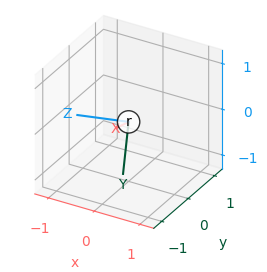

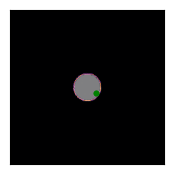

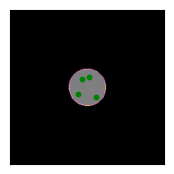

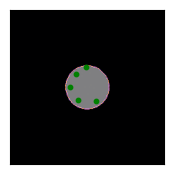

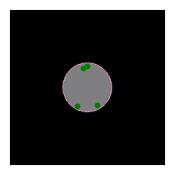

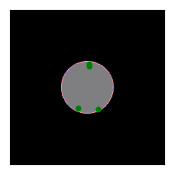

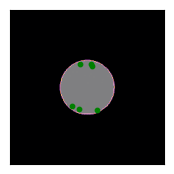

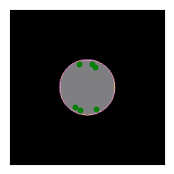

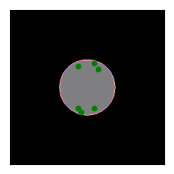

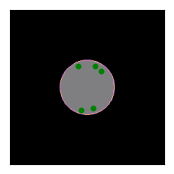

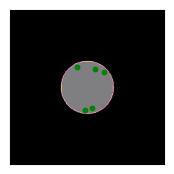

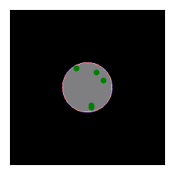

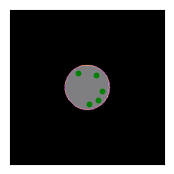

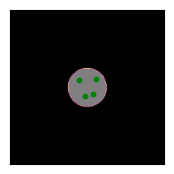

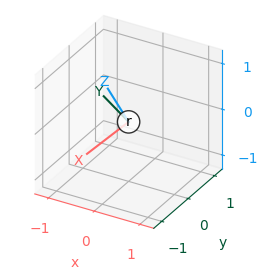

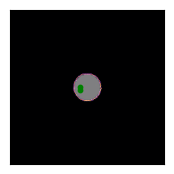

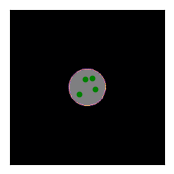

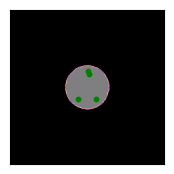

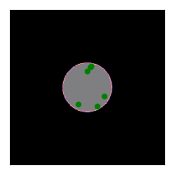

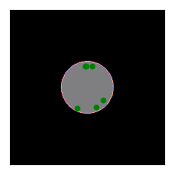

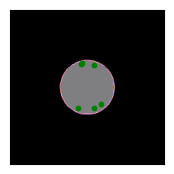

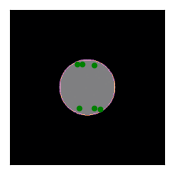

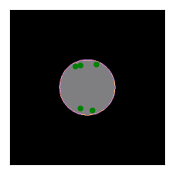

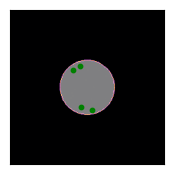

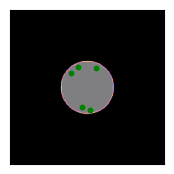

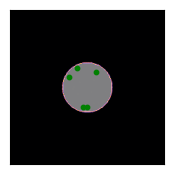

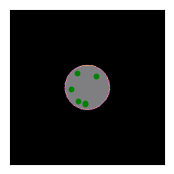

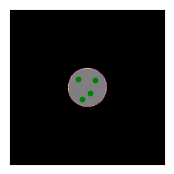

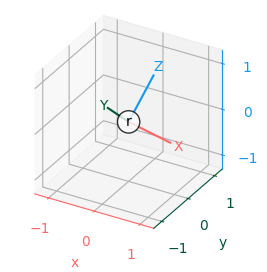

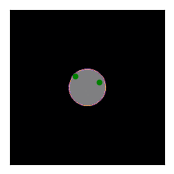

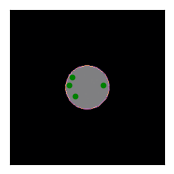

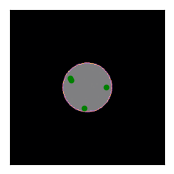

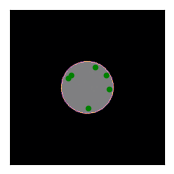

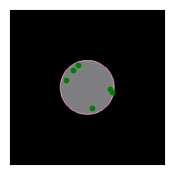

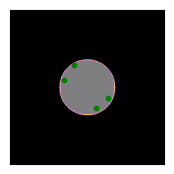

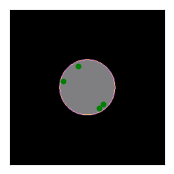

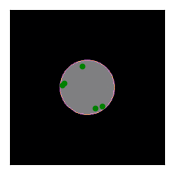

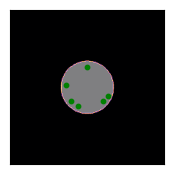

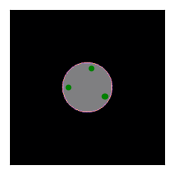

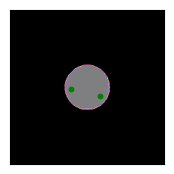

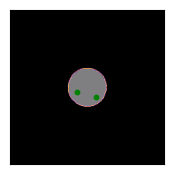

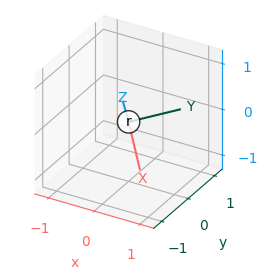

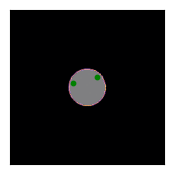

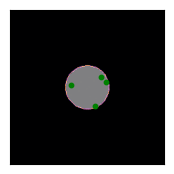

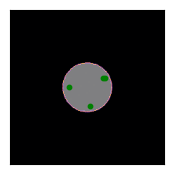

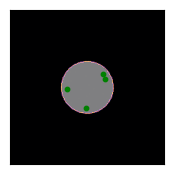

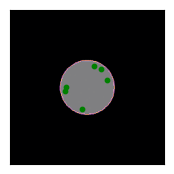

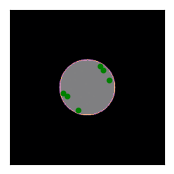

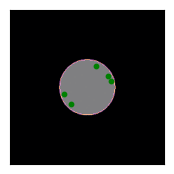

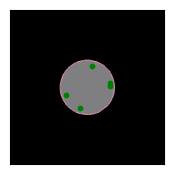

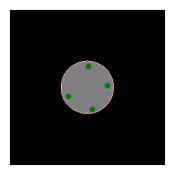

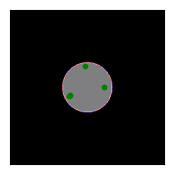

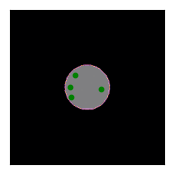

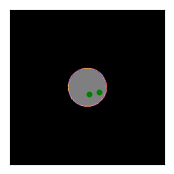

[array([0.25193466, 0.24593235, 0.1004778 ]), array([0.2571833 , 0.24068371, 0.09522917]), array([0.26243194, 0.23543507, 0.08998053]), array([0.26768057, 0.23018643, 0.08473189]), array([0.27292921, 0.2249378 , 0.07948325]), array([0.27817785, 0.21968916, 0.07423461]), array([0.28342649, 0.21444052, 0.06898597]), array([0.28867513, 0.20919188, 0.06373733]), array([0.29392377, 0.20394324, 0.0584887 ]), array([0.29917241, 0.1986946 , 0.05324006]), array([0.30442105, 0.19344596, 0.04799142]), array([0.30966968, 0.18819732, 0.04274278]), array([0.31491832, 0.18294869, 0.03749414]), array([0.32016696, 0.17770005, 0.0322455 ]), array([0.23618874, 0.25835076, 0.10380531]), array([0.24143738, 0.25310212, 0.09855667]), array([0.24668602, 0.24785349, 0.09330803]), array([0.25193466, 0.24260485, 0.08805939]), array([0.2571833 , 0.23735621, 0.08281075]), array([0.26243194, 0.23210757, 0.07756211]), array([0.26768057, 0.22685893, 0.07231348]), array([0.27292921, 0.22161029, 0.06706484]), array([0.

In [24]:
# BIG forloop
prompting_slices_dict = dict()
count = 0
allpoints = []

for t in transform_list:
    transformed_img = scale_transform.global_to_local(image, t)
    matrix_shape = np.array(transformed_img.shape)
    
    # z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:] 
    # zero centric z coord
    z_coord_list = np.linspace(-1,1, num_slices+2)[1:-1] 

    t.plot_self()

    for z in z_coord_list:
        # get the slice of the rotated array
        zidx = int((z+1)/2 * matrix_shape[2])
        slice_transformed_img = transformed_img[:,:,zidx]
        slice_shape = slice_transformed_img.shape
        
        pos_intersects, neg_intersects = get_intersections(matrix_shape, pos_seg, neg_seg, t, z)
        # print(pos_intersects)
        # print(neg_intersects)

        # zero centric intersects
        # pos_intersects = [pt[:2] for pt in pos_intersects]
        # neg_intersects = [pt[:2] for pt in neg_intersects]
        pos_intersects = [[pt[1],pt[0]] for pt in pos_intersects]
        neg_intersects = [[pt[1],pt[0]] for pt in neg_intersects]

        if len(pos_intersects) != 0:
            prompt = [pos_intersects, neg_intersects]
            points, boundary = segmentfunction.segment(predictor, normalize(slice_transformed_img), prompt)
            pointstobeconverted = []
            for a in range(points.shape[0]):
                for b in range(points.shape[1]):
                    if points[a,b] == 1:
                        pointstobeconverted.append([a,b,zidx])
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                allpoints.append(i)

print(allpoints)



In [25]:
inter = scale_transform.get_intersection_point(np.array([110,78,-93]), np.array([110, 141,-94]), 101.951)
print(inter)

None


In [26]:
import open3d as o3d

In [27]:
pcd = o3d.geometry.PointCloud()
n = np.zeros((len(allpoints), 3))
for i in range(len(allpoints)):
    n[i] = allpoints[i]
pcd.points = o3d.utility.Vector3dVector(n)
print("Time taken = ", time.time()-starttime)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")


Time taken =  105.19298195838928
